In [36]:

# conda activate chronocell

import os
import sys

sys.path.append("/mnt/lareaulab/reliscu/programs/FGP_2024")

import Chronocell
from Chronocell.inference import Trajectory
from Chronocell.mixtures import PoissonMixtureSS
from Chronocell.utils import *
from Chronocell.plotting import *
import scipy.stats as stats
from scipy.interpolate import UnivariateSpline, RBFInterpolator
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cmasher as cmr
from tqdm import tqdm
import copy
import anndata as ad

os.chdir("/mnt/lareaulab/reliscu/projects/Chronocell/analyses/janssens_2025_preprint")

In [37]:
# Ref: https://github.com/pachterlab/FGP_2024/blob/main/notebooks/Forebrain.ipynb

In [38]:
adata = ad.read_h5ad("data/janssens_2025_CellRanger_Velocyto_counts_CpG-LNP.h5ad")

In [39]:
gene_names = adata.var_names

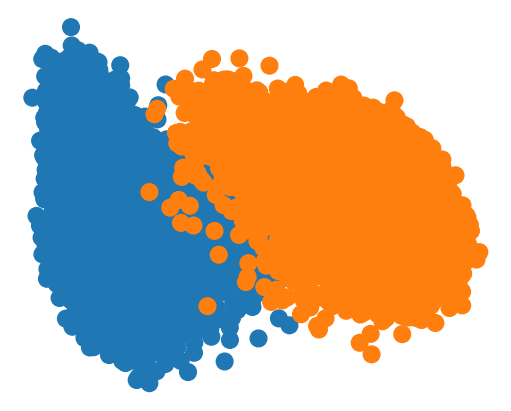

In [41]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder() 
clusters = le.fit_transform(adata.obs['Condition'])
Clusters = set(clusters)

from sklearn.decomposition import PCA
total_UMI = adata.X.toarray().sum(axis=1)
r = total_UMI/np.mean(total_UMI)
pca = PCA(n_components=3)
x = pca.fit_transform(np.log(1+adata.X.toarray()/total_UMI[:,None]*np.mean(total_UMI)))

tab_colors = plt.cm.tab10(np.arange(10))
fig, ax = plt.subplots(1,1,figsize=(5,4))
ax.scatter(-x[:,0],-x[:,1],c=tab_colors[clusters]);
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);

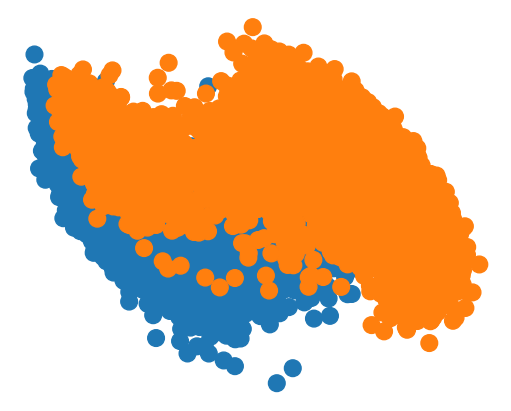

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder() 
clusters = le.fit_transform(adata.obs['newClustersTmp'])
Clusters = set(clusters)

from sklearn.decomposition import PCA
total_UMI = adata.X.toarray().sum(axis=1)
r = total_UMI/np.mean(total_UMI)
pca = PCA(n_components=3)
x = pca.fit_transform(np.log(1+adata.X.toarray()/total_UMI[:,None]*np.mean(total_UMI)))

tab_colors = plt.cm.tab10(np.arange(10))
fig, ax = plt.subplots(1,1,figsize=(5,4))
ax.scatter(-x[:,0],-x[:,1],c=tab_colors[clusters]);
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);

## Gene variance

0.0652578134637036 0.1672950552695369


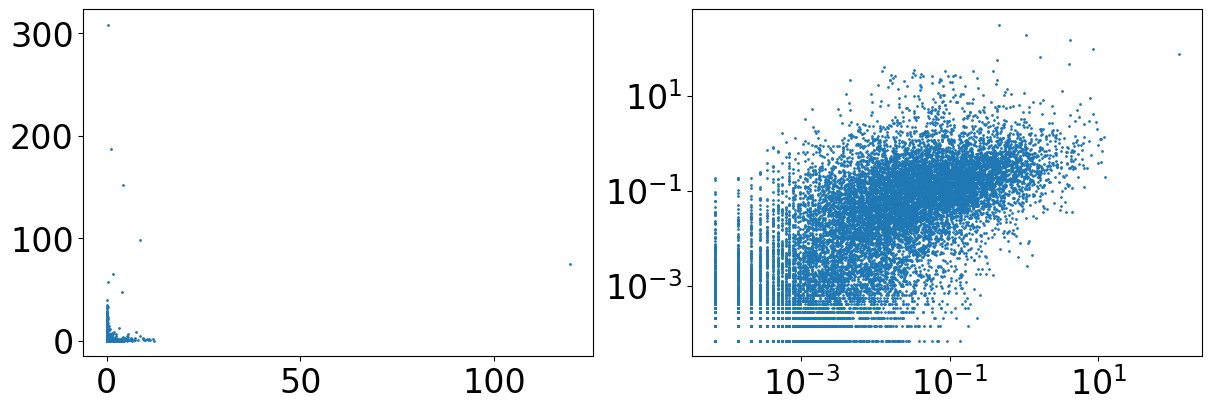

In [51]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].scatter(adata.layers['unspliced'].toarray().mean(0),adata.layers['spliced'].toarray().mean(0),s=1)
ax[1].scatter(adata.layers['unspliced'].toarray().mean(0),adata.layers['spliced'].toarray().mean(0),s=1)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
print(adata.layers['unspliced'].toarray().mean(),adata.layers['spliced'].toarray().mean())

In [52]:
idx = (adata.layers["spliced"].toarray().mean(0) > 0) & (adata.layers["unspliced"].toarray().mean(0) > 0)

U = adata.layers["unspliced"][:,idx].toarray()
n,p = U.shape
X = U
X_cov = np.cov(X,rowvar=False)
X_mean = np.mean(X,axis=0)
X_rho = X_cov/X_mean[:,None]/X_mean[None,:]
su = (np.sum(X_rho)-np.sum(np.diag(X_rho)))/((p-1)*p)
print("s estimated by normalized covariance of total U counts =", str(su))

S = adata.layers["spliced"][:,idx].toarray()
n,p = S.shape
X = S
X_cov = np.cov(X,rowvar=False)
X_mean = np.mean(X,axis=0)
X_rho = X_cov/X_mean[:,None]/X_mean[None,:]
ss = (np.sum(X_rho)-np.sum(np.diag(X_rho)))/((p-1)*p)
print("s estimated by normalized covariance of total S counts =", str(ss))

X = S + U
n,p = X.shape
X_cov = np.cov(X,rowvar=False)
X_mean = np.mean(X,axis=0)
X_rho = X_cov/X_mean[:,None]/X_mean[None,:]
s1 = (np.sum(X_rho)-np.sum(np.diag(X_rho)))/((p-1)*p)
print("s estimated by normalized covariance of total counts =", str(s1))

X_total = X.sum(1)
s2 = (X_total.var()-X_total.mean())/X_total.mean()**2
print("s estimated by total counts =", str(s2))

s estimated by normalized covariance of total U counts = 0.3829342607446627
s estimated by normalized covariance of total S counts = 0.2584064123961144
s estimated by normalized covariance of total counts = 0.2763896751595933
s estimated by total counts = 0.16011406722901214


In [53]:
a=1
sp=s1

X_bar = np.mean(X,axis=0)
X_var = np.var(X,axis=0)
for i in range(5):
    Pgene_mask = (X_mean > 0.01) & (X_var/(a*X_mean + sp*X_mean**2) < 1.2)   
    P = (S + U)[:,Pgene_mask]
    n,p = P.shape
    P_cov = np.cov(P,rowvar=False)
    P_mean = np.mean(P,axis=0)
    P_rho = P_cov/P_mean[:,None]/P_mean[None,:]
    sp = (np.sum(P_rho)-np.sum(np.diag(P_rho)))/((p-1)*p)
    print(Pgene_mask.mean(),"s:", str(sp))

0.47527788424683787 s: 0.2151761274083756
0.4509390571100038 s: 0.2158859120900328
0.4512584642902773 s: 0.21590730801981617
0.4512584642902773 s: 0.21590730801981617
0.4512584642902773 s: 0.21590730801981617


Text(0.02, 0.5, 'CV$^2$')

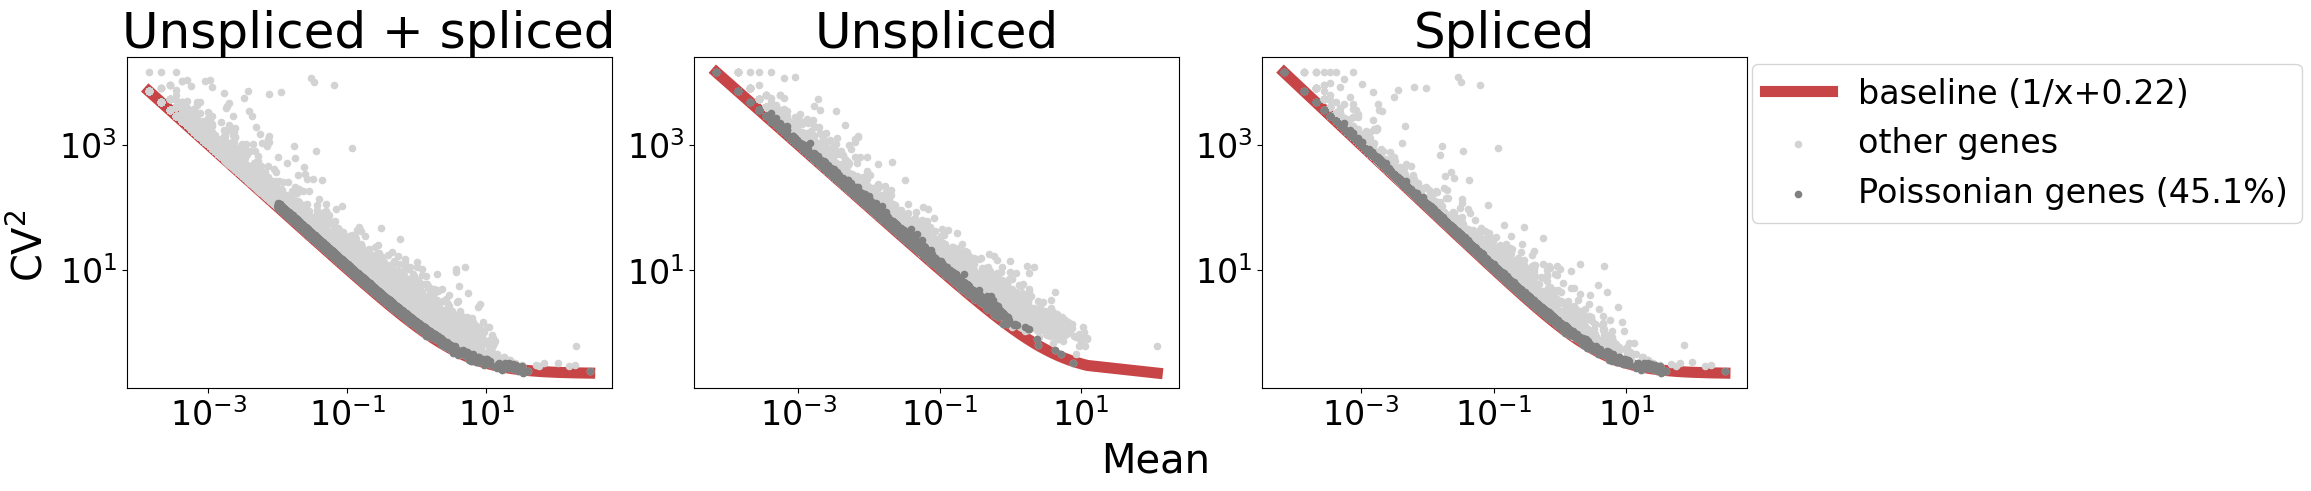

In [54]:
S_mean = np.mean(S,axis=0)
U_mean = np.mean(U,axis=0)
S_var = np.var(S,axis=0)
U_var = np.var(U,axis=0)

fig, ax = plt.subplots(1,3,figsize=(23,4.8))

ax[0].plot(np.sort(X_mean), a/np.sort(X_mean) + sp, color='#c74546', linewidth=8, zorder=0)
ax[0].scatter(X_mean, X_var/X_mean**2,c='lightgray',alpha=1, s=20)
ax[0].scatter(X_mean[Pgene_mask], X_var[Pgene_mask]/X_mean[Pgene_mask]**2, s=20, c='gray')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_title('Unspliced + spliced',fontsize=title_font)

ax[1].plot(np.sort(U_mean), a/np.sort(U_mean) + sp, color='#c74546', linewidth=8, zorder=0)
ax[1].scatter(U_mean, U_var/U_mean**2,c='lightgray',alpha=1, s=20, label='other genes')
ax[1].scatter(U_mean[Pgene_mask], U_var[Pgene_mask]/U_mean[Pgene_mask]**2, s=20, c='gray')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_title('Unspliced',fontsize=title_font)

ax[2].plot(np.sort(S_mean), a/np.sort(S_mean) + sp, color='#c74546', linewidth=8, zorder=0, label='baseline (1/x+'+str(np.around(sp,2))+")")
ax[2].scatter(S_mean, S_var/S_mean**2,c='lightgray',alpha=1, s=20, label='other genes')
ax[2].scatter(S_mean[Pgene_mask], S_var[Pgene_mask]/S_mean[Pgene_mask]**2, s=20, c='gray', label='Poissonian genes ('+str(np.around(100*np.sum(Pgene_mask)/len(X_bar),1))+"%)")
ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[2].set_title('Spliced',fontsize=title_font)

ax[2].legend(loc=(1.01,0.5),fontsize=legend_font)
fig.supxlabel('Mean')
fig.supylabel(r'CV$^2$')

In [55]:
clusters = pd.Series(clusters)

Text(0, 0.5, 'Using total counts')

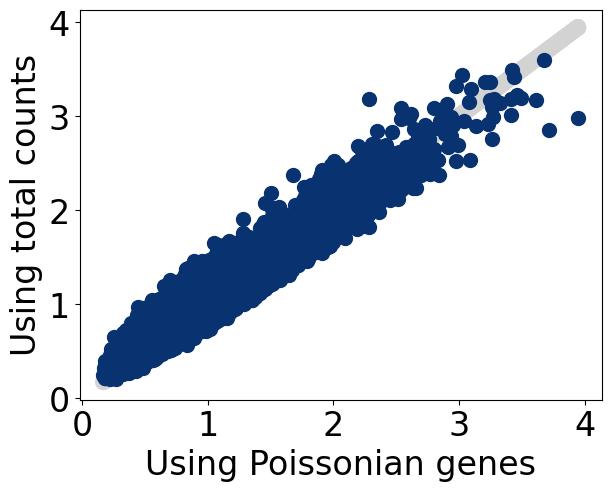

In [56]:
rd = (U + S)[:,Pgene_mask].mean(1)/(U + S)[:,Pgene_mask].mean()
rd_ = X_total/X_total.mean()
fig, ax = plt.subplots(1,1,figsize=(6,4.8))
for i,Cluster in enumerate(Clusters):
    idx = clusters.isin([Cluster])
    ax.scatter(rd[idx],rd_[idx],color=cmap_cluster[i],alpha=1,s=100,label=Cluster)
ax.plot(rd,rd,color='lightgray',zorder=0)
plt.xlabel('Using Poissonian genes',fontsize=legend_font)
plt.ylabel('Using total counts',fontsize=legend_font)
#plt.legend(loc=(1.01,0.3),fontsize=legend_font)

## Select genes

In [57]:
a=1
var_threshold = 1.5
U_mean = adata.layers["unspliced"].toarray().mean(0)
S_mean = adata.layers["spliced"].toarray().mean(0)
U_var = adata.layers["unspliced"].toarray().var(0)
S_var = adata.layers["spliced"].toarray().var(0)
fitted_idx = (U_mean > 0.02) & (S_mean > 0.1) \
    & (U_var/(a*U_mean + sp*U_mean**2) > var_threshold) \
    & (S_var/(a*S_mean + sp*S_mean**2) > var_threshold) \
    & (np.abs(np.log(S_mean/U_mean)) < 4)
fitted_genes=adata.var_names[fitted_idx]

/tmp/ipykernel_3616004/1583935953.py:8: RuntimeWarning: invalid value encountered in divide
  & (U_var/(a*U_mean + sp*U_mean**2) > var_threshold) \
/tmp/ipykernel_3616004/1583935953.py:9: RuntimeWarning: invalid value encountered in divide
  & (S_var/(a*S_mean + sp*S_mean**2) > var_threshold) \
/tmp/ipykernel_3616004/1583935953.py:10: RuntimeWarning: divide by zero encountered in divide
  & (np.abs(np.log(S_mean/U_mean)) < 4)
/tmp/ipykernel_3616004/1583935953.py:10: RuntimeWarning: invalid value encountered in divide
  & (np.abs(np.log(S_mean/U_mean)) < 4)
/tmp/ipykernel_3616004/1583935953.py:10: RuntimeWarning: divide by zero encountered in log
  & (np.abs(np.log(S_mean/U_mean)) < 4)


Ref: https://www.science.org/doi/10.1126/sciimmunol.add3955

CD207 and CD103 were up-regulated during the transition from early immature to late immature cDC1s

Also: see Fig. 2b

- ...early committed cDC1s underwent cell cycle proliferation in situ (“proliferating cDC1s”), as revealed by the expression of cell cycle genes that allowed us to assign cells to the G1, S, or G2-M phase
- During the transition from early immature cDC1s to late immature cDC1s ... the top gene that marked the transition from early to late immature cDC1s was Apol7c, an apolipoprotein with unknown function. In addition, Apoe, a well-established mediator of cholesterol efflux, was increased in expression, whereas Fdps, a rate-limiting enzyme for cholesterol biosynthesis, decreased in expression between early to late immature cDC1s.
- Other genes that marked the transition from early to late immature cDC1s were a group of nuclear receptor proteins (Nr4a2 and Nr4a3) and some early response genes (Egr3 and Egr2; Fig. 3, A and B, and fig. S5C). ... EGR and NR4A proteins have been proposed to be negative regulators of DC immunogenicity.
- Dnase1l3, which encodes an enzyme required for degrading self-DNA from ACs and associated with autoimmunity (63), was up-regulated in late immature cDC1s
- The transition from late immature to early mature cDC1s was characterized by induction of IFN-inducible genes such as Cxcl10, Cxcl9, Iigp1, Ifi47, Gbp2, and Gbp5
- ...the transition to late mature cDC1s was characterized by the expression of several well-established markers such as Cd63, Fscn1, Il4i1, or Socs2

In [58]:
fitted_genes

Index(['Nabp1', 'Stk17b', 'Hspd1', 'Mreg', 'Mcm6', 'Rcsd1', 'Uap1', 'Ifi205',
       'Atf3', 'Hspe1',
       ...
       'Ccl22', 'Zc3h12c', 'Kif23', 'Atp1b3', 'Tmem123', 'Anxa2', 'Gclc',
       'Kif15', 'Pola1', 'Sat1'],
      dtype='object', name='Gene', length=144)

In [59]:
fitted_idx = adata.var_names.isin(fitted_genes)
print(len(fitted_genes))

144


1.7608343902532764 1.7880745801145317


/tmp/ipykernel_3616004/1367263143.py:3: RuntimeWarning: invalid value encountered in divide
  ax[0].scatter(S_mean, S_var/S_mean**2,c='lightgray',alpha=1, s=10)
/tmp/ipykernel_3616004/1367263143.py:4: RuntimeWarning: divide by zero encountered in divide
  ax[0].scatter(S_mean, a/S_mean + sp, c='#c74546', alpha=0.5, s=20)
/tmp/ipykernel_3616004/1367263143.py:11: RuntimeWarning: invalid value encountered in divide
  ax[1].scatter(U_mean, U_var/U_mean**2,c='lightgray',alpha=1, s=10, label='other genes')
/tmp/ipykernel_3616004/1367263143.py:12: RuntimeWarning: divide by zero encountered in divide
  ax[1].scatter(U_mean, a/U_mean + sp, c='#c74546', alpha=0.5, s=20, label='variance baseline')


(14455, 144, 2)

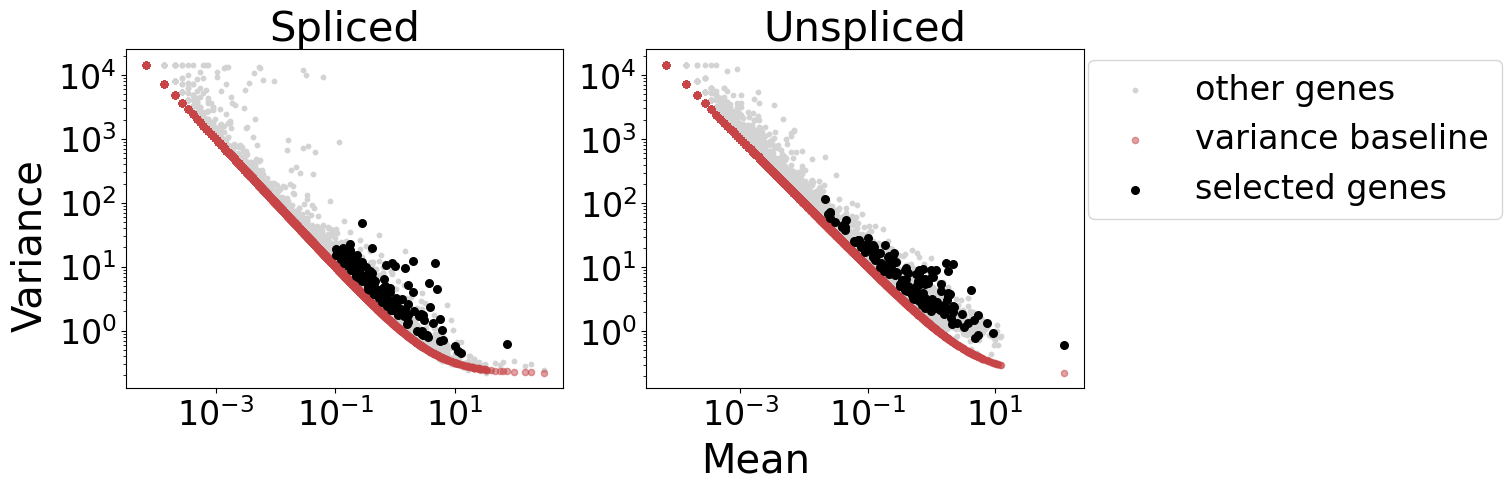

In [60]:
fig, ax = plt.subplots(1,2,figsize=(15,4.8))

ax[0].scatter(S_mean, S_var/S_mean**2,c='lightgray',alpha=1, s=10)
ax[0].scatter(S_mean, a/S_mean + sp, c='#c74546', alpha=0.5, s=20)
ax[0].scatter(S_mean[fitted_idx], S_var[fitted_idx]/S_mean[fitted_idx]**2, s=30, c='k')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_title('Spliced',fontsize=label_font)


ax[1].scatter(U_mean, U_var/U_mean**2,c='lightgray',alpha=1, s=10, label='other genes')
ax[1].scatter(U_mean, a/U_mean + sp, c='#c74546', alpha=0.5, s=20, label='variance baseline')
ax[1].scatter(U_mean[fitted_idx], U_var[fitted_idx]/U_mean[fitted_idx]**2, s=30, c='k', label='selected genes')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].legend(loc=(1.01,0.5),fontsize=legend_font)
ax[1].set_title('Unspliced',fontsize=label_font)
fig.supxlabel('Mean')
fig.supylabel('Variance')

X=np.zeros((adata.n_obs,fitted_idx.sum(),2))
X[:,:,0]=adata.layers["unspliced"][:,fitted_idx].toarray()
X[:,:,1]=adata.layers["spliced"][:,fitted_idx].toarray()
fitted_genes=adata.var_names[fitted_idx]
print(X[:,:,0].mean(),X[:,:,1].mean())
X.shape

1.7608343902532764 1.7880745801145317


/tmp/ipykernel_3616004/1367263143.py:3: RuntimeWarning: invalid value encountered in divide
  ax[0].scatter(S_mean, S_var/S_mean**2,c='lightgray',alpha=1, s=10)
/tmp/ipykernel_3616004/1367263143.py:4: RuntimeWarning: divide by zero encountered in divide
  ax[0].scatter(S_mean, a/S_mean + sp, c='#c74546', alpha=0.5, s=20)
/tmp/ipykernel_3616004/1367263143.py:11: RuntimeWarning: invalid value encountered in divide
  ax[1].scatter(U_mean, U_var/U_mean**2,c='lightgray',alpha=1, s=10, label='other genes')
/tmp/ipykernel_3616004/1367263143.py:12: RuntimeWarning: divide by zero encountered in divide
  ax[1].scatter(U_mean, a/U_mean + sp, c='#c74546', alpha=0.5, s=20, label='variance baseline')


(14455, 144, 2)

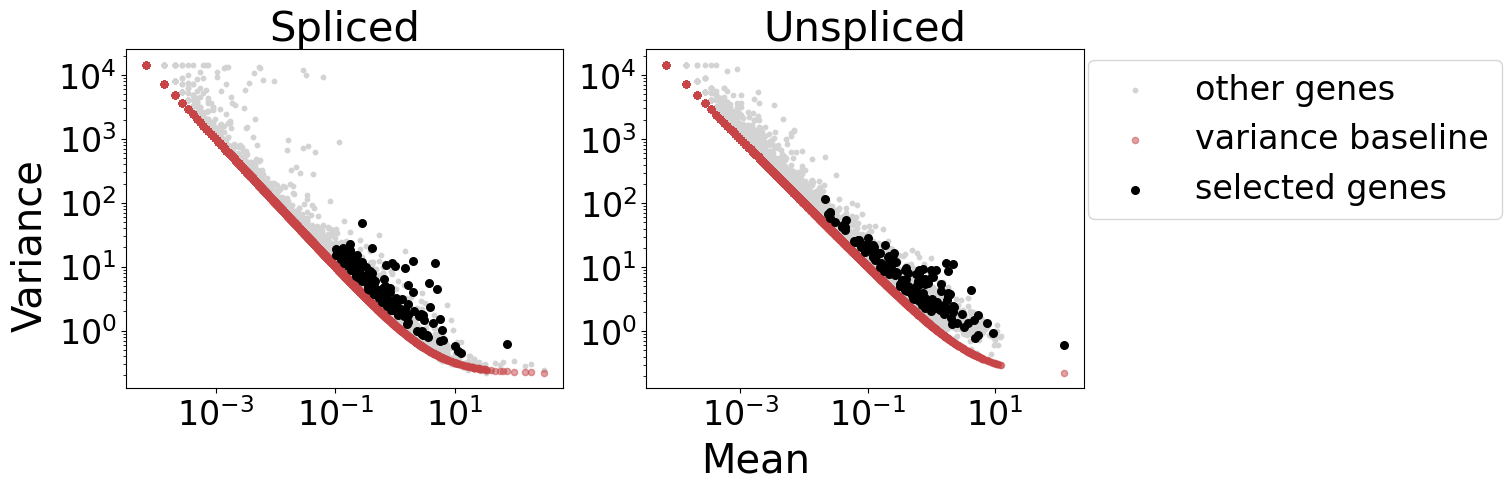

In [61]:
fig, ax = plt.subplots(1,2,figsize=(15,4.8))

ax[0].scatter(S_mean, S_var/S_mean**2,c='lightgray',alpha=1, s=10)
ax[0].scatter(S_mean, a/S_mean + sp, c='#c74546', alpha=0.5, s=20)
ax[0].scatter(S_mean[fitted_idx], S_var[fitted_idx]/S_mean[fitted_idx]**2, s=30, c='k')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_title('Spliced',fontsize=label_font)


ax[1].scatter(U_mean, U_var/U_mean**2,c='lightgray',alpha=1, s=10, label='other genes')
ax[1].scatter(U_mean, a/U_mean + sp, c='#c74546', alpha=0.5, s=20, label='variance baseline')
ax[1].scatter(U_mean[fitted_idx], U_var[fitted_idx]/U_mean[fitted_idx]**2, s=30, c='k', label='selected genes')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].legend(loc=(1.01,0.5),fontsize=legend_font)
ax[1].set_title('Unspliced',fontsize=label_font)
fig.supxlabel('Mean')
fig.supylabel('Variance')

X=np.zeros((adata.n_obs,fitted_idx.sum(),2))
X[:,:,0]=adata.layers["unspliced"][:,fitted_idx].toarray()
X[:,:,1]=adata.layers["spliced"][:,fitted_idx].toarray()
fitted_genes=adata.var_names[fitted_idx]
print(X[:,:,0].mean(),X[:,:,1].mean())
X.shape

## Mixtures fitting

In [62]:
Clusters = set(clusters)
cell_idx = clusters.isin(Clusters)
X_mix = X[cell_idx]

1 -521.6092629189628 -521.6291868207269 -521.7046864107816
2 -397.773757276407 -397.8037123092676 -397.91722384570403
3 -363.3109629842954 -363.3509491482525 -363.50247263107065
4 -354.6701094864521 -354.7201267815057 -354.90966221070556
5 -344.05922842408347 -344.1192768502336 -344.34682422581517
6 -344.22656427935596 -344.2966438366026 -344.56220315856586


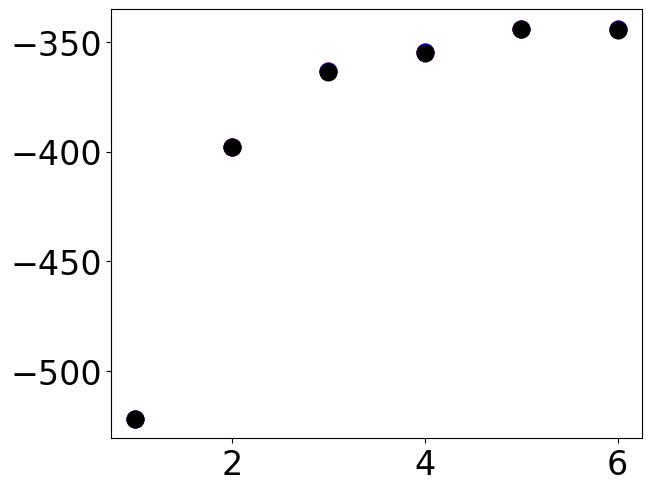

In [63]:
PMs = []
for nc in range(1,7):
    PM = PoissonMixtureSS(n_components=nc,verbose=0)
    Q, elbo = PM.fit(X_mix,warm_start=False,read_depth=rd,epoch=5,n_init=3)
    PMs.append(PM)
    plt.scatter(nc,elbo,color='r')
    plt.scatter(nc,PM.compute_AIC(X_mix),color='b')
    plt.scatter(nc,PM.compute_BIC(X_mix),color='k')
    print(nc,PM.compute_lower_bound(X_mix),PM.compute_AIC(X_mix),PM.compute_BIC(X_mix))

In [64]:
PM = PoissonMixtureSS(n_components=4,verbose=0)
Q, elbo = PM.fit(X,warm_start=False,read_depth=rd,epoch=10,n_init=10)
PM.Q = Q
PM.elbo = elbo
PM.weights

array([0.33872146, 0.07947388, 0.48834026, 0.0934644 ])

(np.float64(-351.91193490621436),
 array([0.33872146, 0.07947388, 0.48834026, 0.0934644 ]))

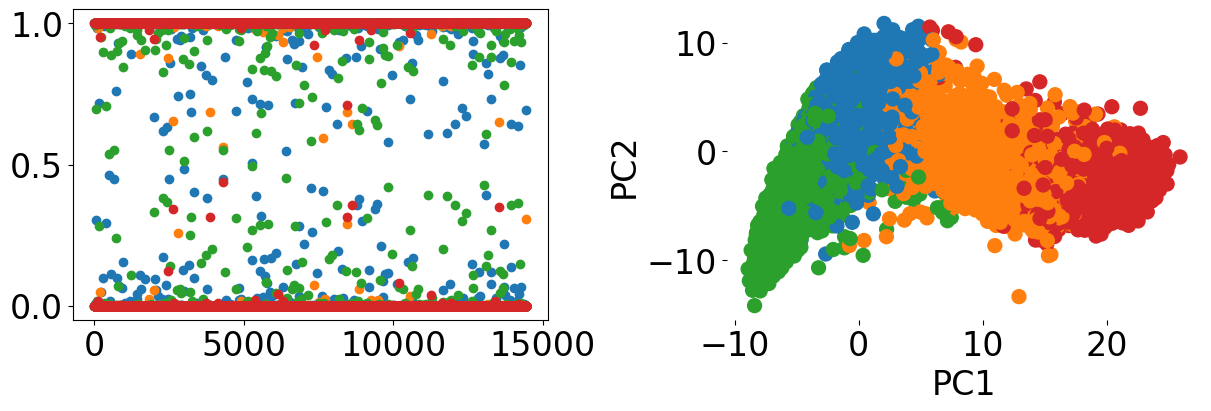

In [65]:
tab_colors = plt.cm.tab10(np.arange(10))
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(Q[np.argsort(clusters)],'.',);
ax[1].scatter(x[:,0],x[:,1],c=tab_colors[np.argmax(Q,axis=-1)],s=100);
ax[1].set_xlabel('PC1',fontsize=24)
ax[1].set_ylabel('PC2',fontsize=24)
ax[1].set_frame_on(False)

elbo, PM.weights

## Trajectory fitting

In [ ]:
# Note: θ = (α, β, γ, τ)
# Transcription rates (one per state)	

n = len(Clusters)

traj_params={'r':rd, "lambda_tau":0, "lambda_a":0}
topo = np.array([np.array(list(range(0, n)))], dtype=int)
tau = np.linspace(0, 2, 8)  # Generates initial switching times between each trajectory (assume all genes have the same switching time for now)
traj = Trajectory(topo, tau, model="two_species_ss", verbose=1)
traj = traj.fit(X, warm_start=False, fit_tau=True, params=traj_params, Q=None, parallel=True, n_threads=4, epoch=3, n_init=1)

fitting with multiple random initializations
trial 1


100%|██████████| 3/3 [00:08<00:00,  2.76s/it]


In [238]:
tau = traj.tau # State transition times (global)
time_grid = traj.t # Process time intervals

In [245]:
time_states = np.zeros(shape=time_grid.shape, dtype=int) 
for k in range(1, len(tau)):  # Start at 1 (state 0 is implicit)
    idx = (time_grid <= tau[k]) & (time_grid > tau[k - 1])
    time_states[idx] = k - 1

In [249]:
def _get_state_per_time(tau, time_grid):
    time_states = np.zeros(shape=time_grid.shape, dtype=int) 
    for k in range(1, len(tau)):  # Start at 1 (state 0 is implicit)
        idx = (time_grid <= tau[k]) & (time_grid > tau[k - 1])
        time_states[idx] = k - 1
    return time_states

In [ ]:
state_per_time = _get_state_per_time(tau, time_grid)
alpha_per_time = np.repeat(alphas[1:], np.bincount(state_per_time))
alpha_per_time 

array([0.03671488, 0.03671488, 0.03671488, 0.03671488, 0.03671488,
       0.03671488, 0.03671488, 0.03671488, 0.03671488, 0.03671488,
       0.03671488, 0.03671488, 0.03671488, 0.03671488, 0.03671488,
       0.03671488, 0.03671488, 0.03671488, 0.03671488, 0.03671488,
       0.03671488, 0.03671488, 0.03671488, 0.03671488, 0.03671488,
       0.03671488, 0.03671488, 0.03671488, 0.03671488, 0.03671488,
       0.03671488, 0.03671488, 0.07369179, 0.07369179, 0.07369179,
       0.07369179, 0.07369179, 0.07369179, 0.07369179, 0.07369179,
       0.07369179, 0.07369179, 0.07369179, 0.07369179, 0.07369179,
       0.07369179, 0.07369179, 0.07369179, 0.07369179, 0.07369179,
       0.07369179, 0.07369179, 0.07369179, 0.06828627, 0.06828627,
       0.06828627, 0.06828627, 0.06828627, 0.06828627, 0.06828627,
       0.06828627, 0.06828627, 0.06828627, 0.06828627, 0.06828627,
       0.06828627, 0.06828627, 0.06828627, 0.06828627, 0.10705417,
       0.10705417, 0.10705417, 0.10705417, 0.10705417, 0.10705

In [ ]:
def reconstruct_past_mrna(traj, gene_idx, n_steps_back=20):
    past_mrna = np.zeros((traj.X.shape[0], (n_steps_back + 1)))
        
    for cell_idx in range(traj.X.shape[0]):
        lambda_u = [traj.X[cell_idx, gene_idx, 0]] # Transcriptional history starts with observed data
        lambda_s = [traj.X[cell_idx, gene_idx, 1]]
        
        tau = traj.tau # State transition times (global)
        time_grid = traj.t # Process time intervals
        theta = traj.theta[gene_idx, :] # Gene-specific parameters
        alphas = theta[:len(traj.topo.flatten())] # State-specific transcription rates
        beta = theta[-2] # Splicing rate
        gamma = theta[-1] # Degradation rate
        
        def _get_state_per_time(tau, time_grid):
            time_states = np.zeros(shape=time_grid.shape, dtype=int) 
            for k in range(1, len(tau)):  # Start at 1 (state 0 is implicit)
                idx = (time_grid <= tau[k]) & (time_grid > tau[k - 1])
                time_states[idx] = k - 1
            return time_states

        state_per_time = _get_state_per_time(tau, time_grid)
        alpha_per_time = np.repeat(alphas[1:], np.bincount(state_per_time)) # Get transcription rate for corresponding time step
        
        posterior_prob = traj.Q[cell_idx, 0, :] # Posterior probabilities of cell being in a given state time
        current_state_idx = np.argmax(posterior_prob) # Most likely state time
        time_dt = list(reversed(time_grid[:(current_state_idx + 1)]))[0:(n_steps_back + 1)] # State time, starting at current state and going backwards `n_steps_back`
        alphas_dt = list(reversed(alpha_per_time[:(current_state_idx + 1)]))[0:(n_steps_back + 1)] # Transcription rate for each state time
        
        if (len(time_dt) < n_steps_back): 
            # If cell reaches end of trajectory, include initial conditions in the cell's history
            time_dt = np.append(time_dt, time_grid[0])
            alphas_dt = np.append(alphas_dt, alpha_per_time[0])
            
        # Initial condition (only need to calculate once per gene)
        d = beta / ((beta - gamma) * gamma + eps)
        lambda_u0 = alphas_dt[-1]
        lambda_s0 = alphas_dt[-1] * d
            
        for k in range(1, len(time_dt)):
            if time_dt[k] == time_dt[k - 1]: # Initial conditions
                lambda_u_k1 = lambda_u0
                lambda_s_k1 = lambda_s0
            else:
                t_k = time_dt[k]  # Current time (chronologically earlier)
                t_k1 = time_dt[k - 1] # Previous time (chronologically later)
                alpha_k1 = alphas_dt[k - 1] # Previous transcription rate (chronologically later)
                
                # Solve for past λ_u (based on current λ_u)
                lambda_u_k1 = (lambda_u[-1] - (alpha_k1 / beta) * (1 - np.exp(-beta * (t_k - t_k1)))) / np.exp(-beta * (t_k - t_k1))
                lambda_u_k1 = max(lambda_u_k1, 0) # Ensure non-negative mRNA
                
                # Solve for past λ_s (based on current λ_s and past λ_u)
                lambda_s_k1 = (lambda_s[-1] - (beta / (beta - gamma)) * lambda_u_k1 + (beta * alpha_k1) / (gamma * (beta - gamma)) * (1 - np.exp(-gamma * (t_k - t_k1)))) / np.exp(-gamma * (t_k - t_k1))
                lambda_s_k1 = max(lambda_s_k1, 0)  
                
            lambda_u.append(lambda_u_k1)
            lambda_s.append(lambda_s_k1)

        # Pad array if steady state is reached in less than `n_steps_back`
        steps_to_extend = (n_steps_back) - len(time_dt) + 1
        if (steps_to_extend > 0):
            lambda_s = np.concatenate((lambda_s, np.full(steps_to_extend, np.nan)))

        past_mrna[cell_idx, :] = lambda_s
        
    return past_mrna

In [295]:
n_steps_back = 20
gene_idx = 1
cell_idx = 993

past_mrna_gene = reconstruct_past_mrna(traj, gene_idx, n_steps_back)

In [299]:
max(np.nansum(past_mrna_gene, axis=1))

np.float64(264.0023270002627)

In [300]:
min(np.nansum(past_mrna_gene, axis=1))

np.float64(0.0)